In [ ]:
!pip install keras

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from tensorflow.keras.metrics import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
from glob import glob
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Check if TensorFlow is using a GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


### **Load Data**

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# sort images
data = glob('/content/drive/MyDrive/Computer Vision/Dataset_BUSI_with_GT/*/*')
print(f"'normal' class has {len([i for i in data if 'normal' in i and 'mask' not in i])} images and {len([i for i in data if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in data if 'benign' in i and 'mask' not in i])} images and {len([i for i in data if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in data if 'malignant' in i and 'mask' not in i])} images and {len([i for i in data if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in data if 'mask' not in i])} images and {len([i for i in data if 'mask' in i])} masks.")

'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


some images have multiple masks

### **Load Images**

In [ ]:
def load_images(path):
  img = cv2.imread(path)
  # if img is None:
  #   print(f"Error loading image: {path}")
  #   return None
  img = cv2.resize(img,(128,128))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = img/255.0 # Normalize
  return img

def load_data(path):
  images = []
  masks = []
  more_than_one_mask = 0 # track whether previous file processed was a mask
  for i in sorted(glob(path)): # process images/masks in consistent order
    img = load_images(i)
    if 'mask' in i: # check if file is a mask
      if more_than_one_mask:
        masks[-1] += img # add to last mask
        # normalize mask to 0 or 1
        masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
      else:
        masks.append(img)
        more_than_one_mask = 1 # no more masks for this image
    else: # if file is not a mask
      images.append(img)
      more_than_one_mask = 0
  return np.array(images), np.array(masks)

In [ ]:
X, y = load_data('/content/drive/MyDrive/Computer Vision/Dataset_BUSI_with_GT/*/*')

In [ ]:
print(X.shape)
print(y.shape)

(780, 128, 128)
(780, 128, 128)


### **Visualize Data**

Text(0.5, 1.0, 'Image with Mask')

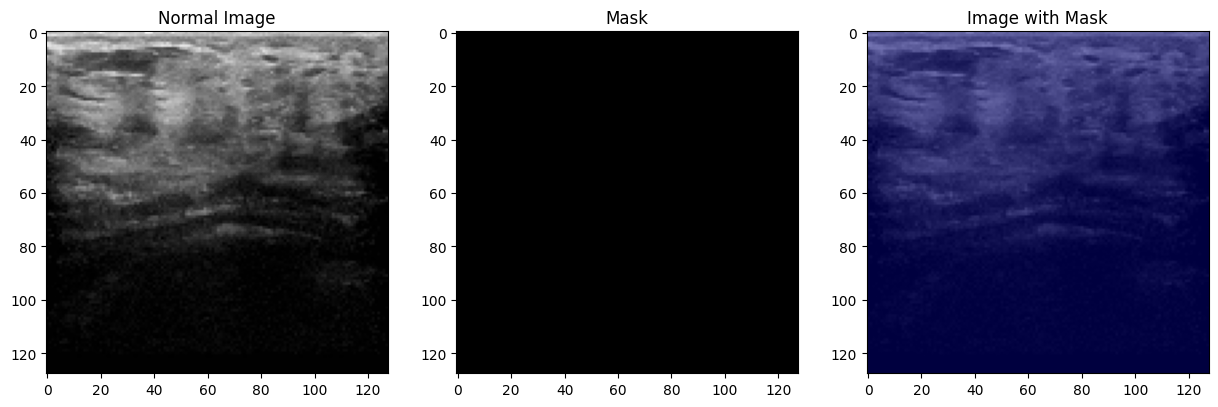

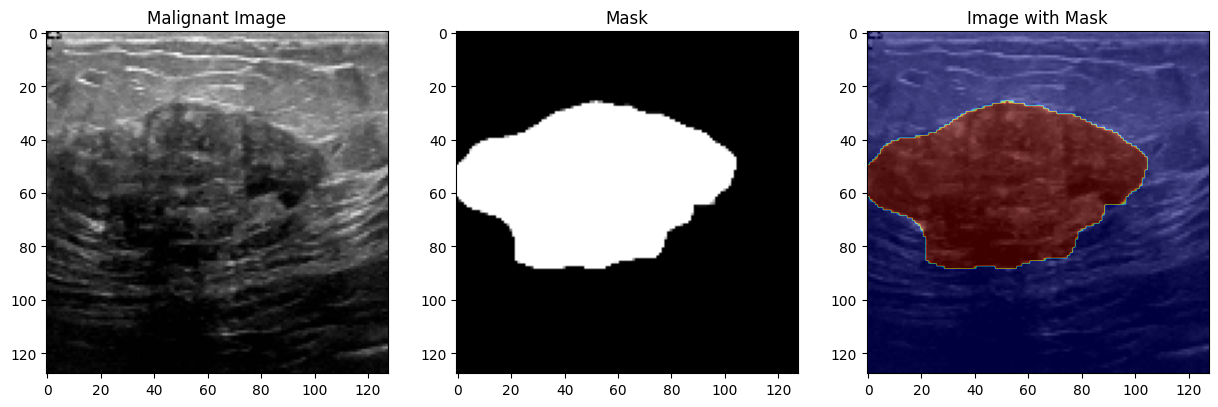

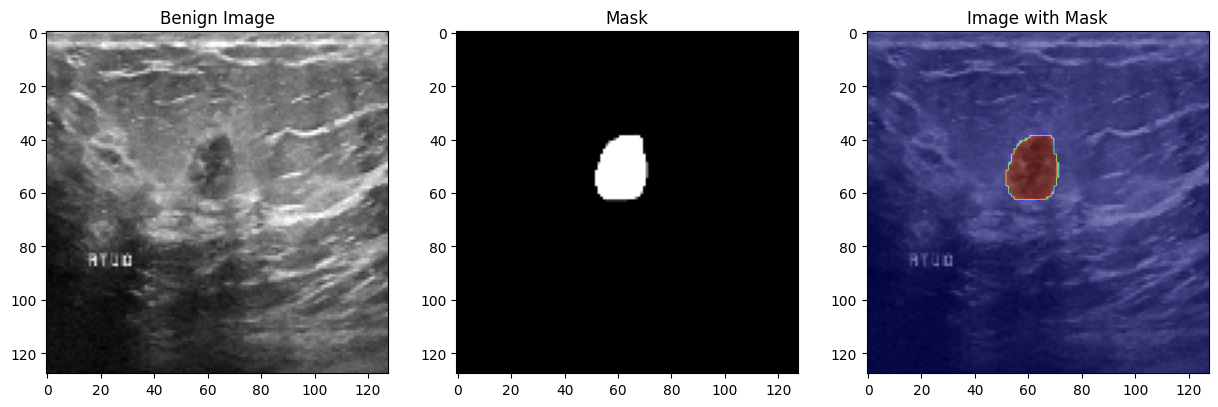

In [ ]:
# Show union of image and mask

# Normal
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
i = np.random.randint(647, 780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Normal Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Image with Mask')

# Malignant
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
i = np.random.randint(437, 647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Malignant Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Image with Mask')

# Benign
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Benign Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Image with Mask')


Text(0.5, 1.0, 'Benign')

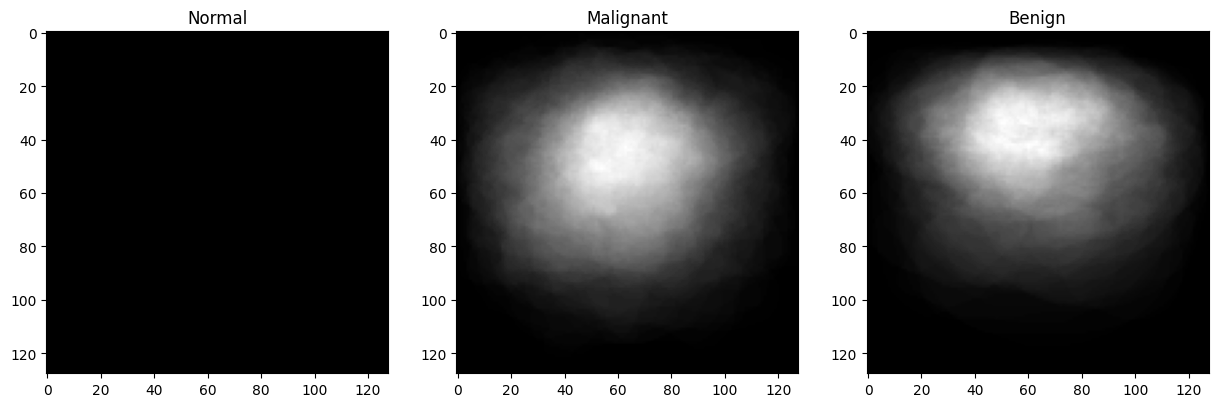

In [ ]:
# View of masks in each class

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(sum(y[647:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y[437:647]), cmap='gray')
ax[1].set_title('Malignant')
ax[2].imshow(sum(y[:437]), cmap='gray')
ax[2].set_title('Benign')

In [ ]:
# Drop Normal class
X = X[:647]
y = y[:647]
print(X.shape)
print(y.shape)

# Add dimension, grayscale images have 1 channel
X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)
print(X.shape)
print(y.shape)

(647, 128, 128)
(647, 128, 128)
(647, 128, 128, 1)
(647, 128, 128, 1)


In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(466, 128, 128, 1)
(98, 128, 128, 1)
(466, 128, 128, 1)
(98, 128, 128, 1)


# **No Transfer Learning**

### Model

In [ ]:
# Conv
# extract features from images
# relu introduces non-linearity (sets negative values to 0)
# weights initialized using He method
# depth = num_filters
def conv(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(inputs)
    x = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(x)
    return x

# Encoder
# extract features and reduce spatial dimensions to focus on the most important features
# max pooling downsamples feature map
def encoder(inputs, num_filters):
    x = conv(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

# Decoder
# upsample feature map to restore spatial dimensions via skip connection
def decoder(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs) # transposed convolution
    x = concatenate([x, skip_features]) # combine features from encoder with upsampled features
    x = conv(x, num_filters)
    return x

In [ ]:
def build_model():
  input_layer = Input((128, 128, 1))

  # downsampling
  s1, p1 = encoder(input_layer, 64)
  s2, p2 = encoder(p1, 128)
  s3, p3 = encoder(p2, 256)
  s4, p4 = encoder(p3, 512)

  b1 = conv(p4, 1024) # bottleneck, abstract features combined with info. from entire image

  # upsampling
  d1 = decoder(b1, s4, 512)
  d2 = decoder(d1, s3, 256)
  d3 = decoder(d2, s2, 128)
  d4 = decoder(d3, s1, 64)

  outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
  model = Model(input_layer, outputs, name="U-Net")
  return model

model = build_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

### Training


In [ ]:
results = model.fit(X_train, y_train, batch_size=16, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7970 - loss: 0.4449 - val_accuracy: 0.9022 - val_loss: 0.3380
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9068 - loss: 0.3195 - val_accuracy: 0.9022 - val_loss: 0.3939
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9042 - loss: 0.2864 - val_accuracy: 0.9022 - val_loss: 0.2569
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9044 - loss: 0.2474 - val_accuracy: 0.9062 - val_loss: 0.2455
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9025 - loss: 0.2342 - val_accuracy: 0.9041 - val_loss: 0.2431
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9074 - loss: 0.2300 - val_accuracy: 0.9151 - val_loss: 0.2089
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9129 - loss: 0.2286 - val_accuracy: 0.9116 - val_loss: 0.2498
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9145 - loss: 0.2312 - val_accuracy: 0.9135 -

### Plot Loss and Accuracy

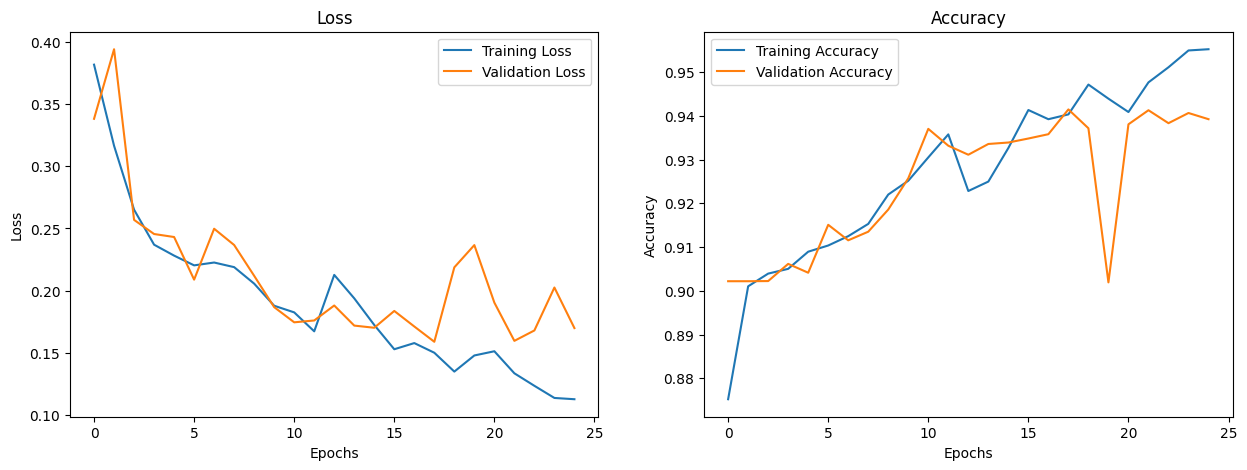

In [ ]:
# No Transfer Learning
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(results.epoch, results.history['loss'], label='Training Loss')
ax[0].plot(results.epoch, results.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(results.epoch, results.history['accuracy'], label='Training Accuracy')
ax[1].plot(results.epoch, results.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

### Evaluate

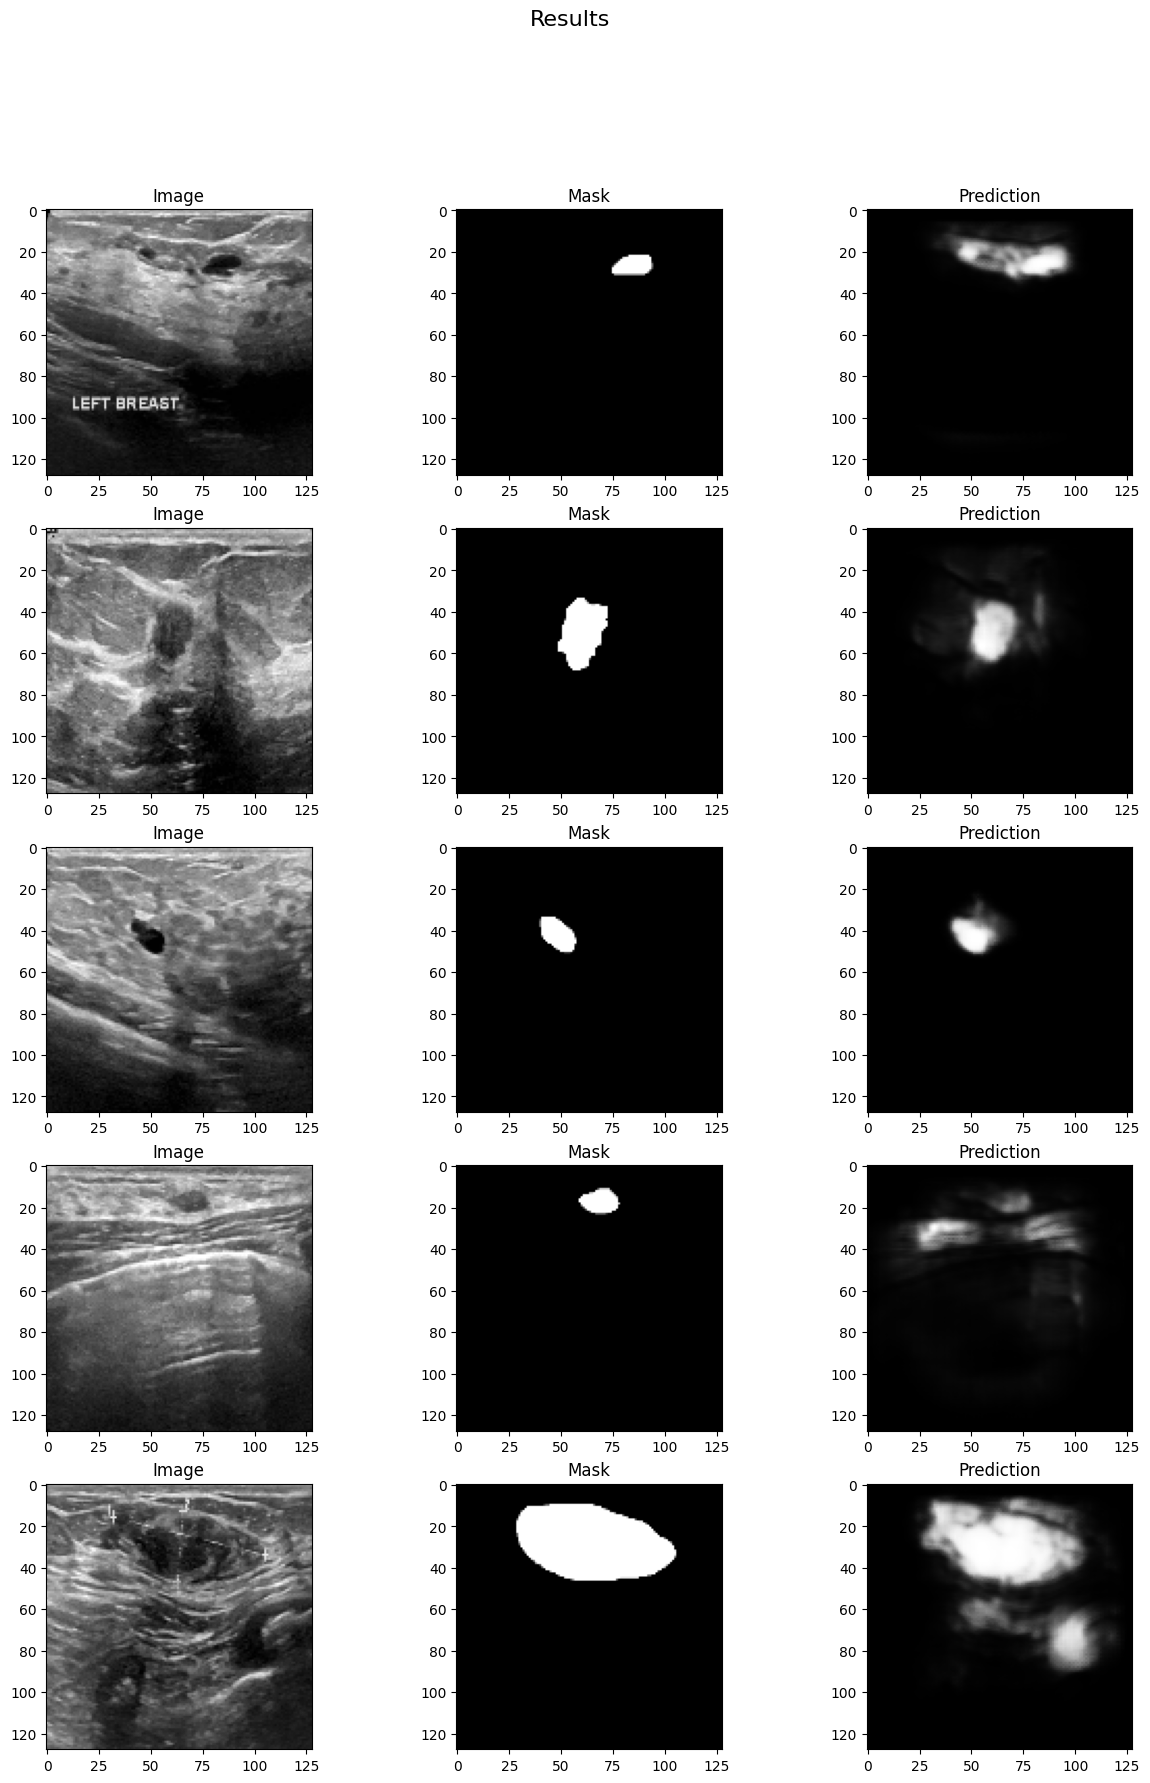

In [ ]:
# No Transfer Learning
fig, ax = plt.subplots(5, 3, figsize=(15, 20))

# Generate 5 random indices
rand_indices = np.random.randint(0, X_test.shape[0], 5)

# Iterate through the random indices and plot the results
for i, rand in enumerate(rand_indices):
    ax[i, 0].imshow(X_test[rand].squeeze(), cmap='gray')
    ax[i, 0].set_title('Image')

    ax[i, 1].imshow(y_test[rand].squeeze(), cmap='gray')
    ax[i, 1].set_title('Mask')

    prediction = model.predict(np.expand_dims(X_test[rand], 0), verbose=0)
    ax[i, 2].imshow(prediction.squeeze(), cmap='gray')
    ax[i, 2].set_title('Prediction')

fig.suptitle('Results', fontsize=16)
plt.show()


In [ ]:
# No Transfer Learning

# Predict the output
y_pred = model.predict(X_test, verbose=0)

threshold = y_pred > 0.5

print(f"Shape of y_pred: {y_pred.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of threshold: {threshold.shape}")

# Flatten the arrays if needed, convert to 1D
y_test_flat = y_test.flatten()
threshold_flat = threshold.flatten() # flatten binary mask from predictions

# IOU
mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)
mean_iou.update_state(y_test_flat, threshold_flat)
print("Mean IoU on test set: {:.3f}".format(mean_iou.result()))

# Precision
precision = tf.keras.metrics.Precision()
precision.update_state(y_test_flat, threshold_flat)
print(f"Precision: {precision.result().numpy()}")

# Recall
recall = tf.keras.metrics.Recall()
recall.update_state(y_test_flat, threshold_flat)
print(f"Recall: {recall.result().numpy()}")

# Accuracy
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y_test_flat, threshold_flat)
print(f"Accuracy: {accuracy.result().numpy()}")


Shape of y_pred: (98, 128, 128, 1)
Shape of y_test: (98, 128, 128, 1)
Shape of threshold: (98, 128, 128, 1)
Precision: 0.7359100580215454
Recall: 0.6453455090522766
Accuracy: 0.9461601376533508


# **Transfer Learning**

### Model/Train

In [ ]:
# VGG16 model as the encoder
def build_model():
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    input_layer = vgg16.input
    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output
    p4 = vgg16.get_layer("block5_conv3").output

    # up-sampling
    b1 = conv(p4, 1024)  # Bottleneck

    d1 = decoder(b1, s4, 512)
    d2 = decoder(d1, s3, 256)
    d3 = decoder(d2, s2, 128)
    d4 = decoder(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(input_layer, outputs, name="U-Net_with_VGG16")
    return model

# Building and compiling the model
model = build_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Convert grayscale images to RGB
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_train_rgb = X_train_rgb.reshape(-1, 128, 128, 3)  # Ensure shape is (num_samples, 128, 128, 3)

X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_val_rgb = X_val_rgb.reshape(-1, 128, 128, 3)  # Ensure shape is (num_samples, 128, 128, 3)

# Train
results = model.fit(X_train_rgb, y_train, batch_size=16, epochs=30, validation_data=(X_val_rgb, y_val))



Model: "U-Net_with_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 8, 8, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├──────────────────────

 Total params: 41,061,057 (156.64 MB)

 Trainable params: 41,061,057 (156.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.7869 - loss: 1.5814 - val_accuracy: 0.9022 - val_loss: 0.3275
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.8972 - loss: 0.3208 - val_accuracy: 0.9062 - val_loss: 0.3130
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9025 - loss: 0.2936 - val_accuracy: 0.9023 - val_loss: 0.2822
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9088 - loss: 0.2603 - val_accuracy: 0.9071 - val_loss: 0.2378
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9067 - loss: 0.2409 - val_accuracy: 0.9048 - val_loss: 0.2705
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9133 - loss: 0.2281 - val_accuracy: 0.9070 - val_loss: 0.2523
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9024 - loss: 0.2438 - val_accuracy: 0.9059 - val_loss: 0.2316
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9126 - loss: 0.2189 - val_accuracy: 0

### Plot Loss and Accuracy

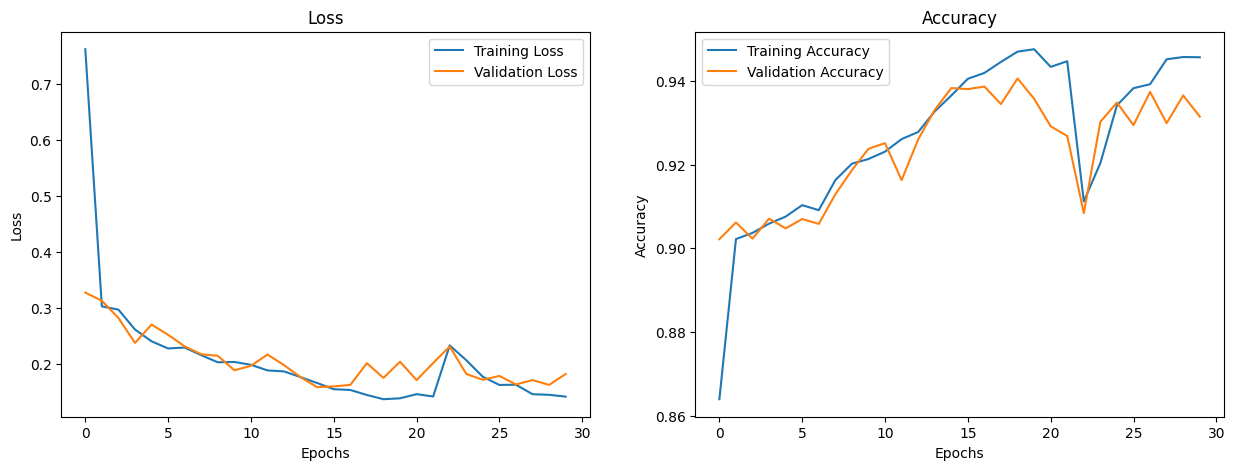

In [ ]:
# Transfer Learning
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(results.epoch, results.history['loss'], label='Training Loss')
ax[0].plot(results.epoch, results.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(results.epoch, results.history['accuracy'], label='Training Accuracy')
ax[1].plot(results.epoch, results.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()


### Evaluate

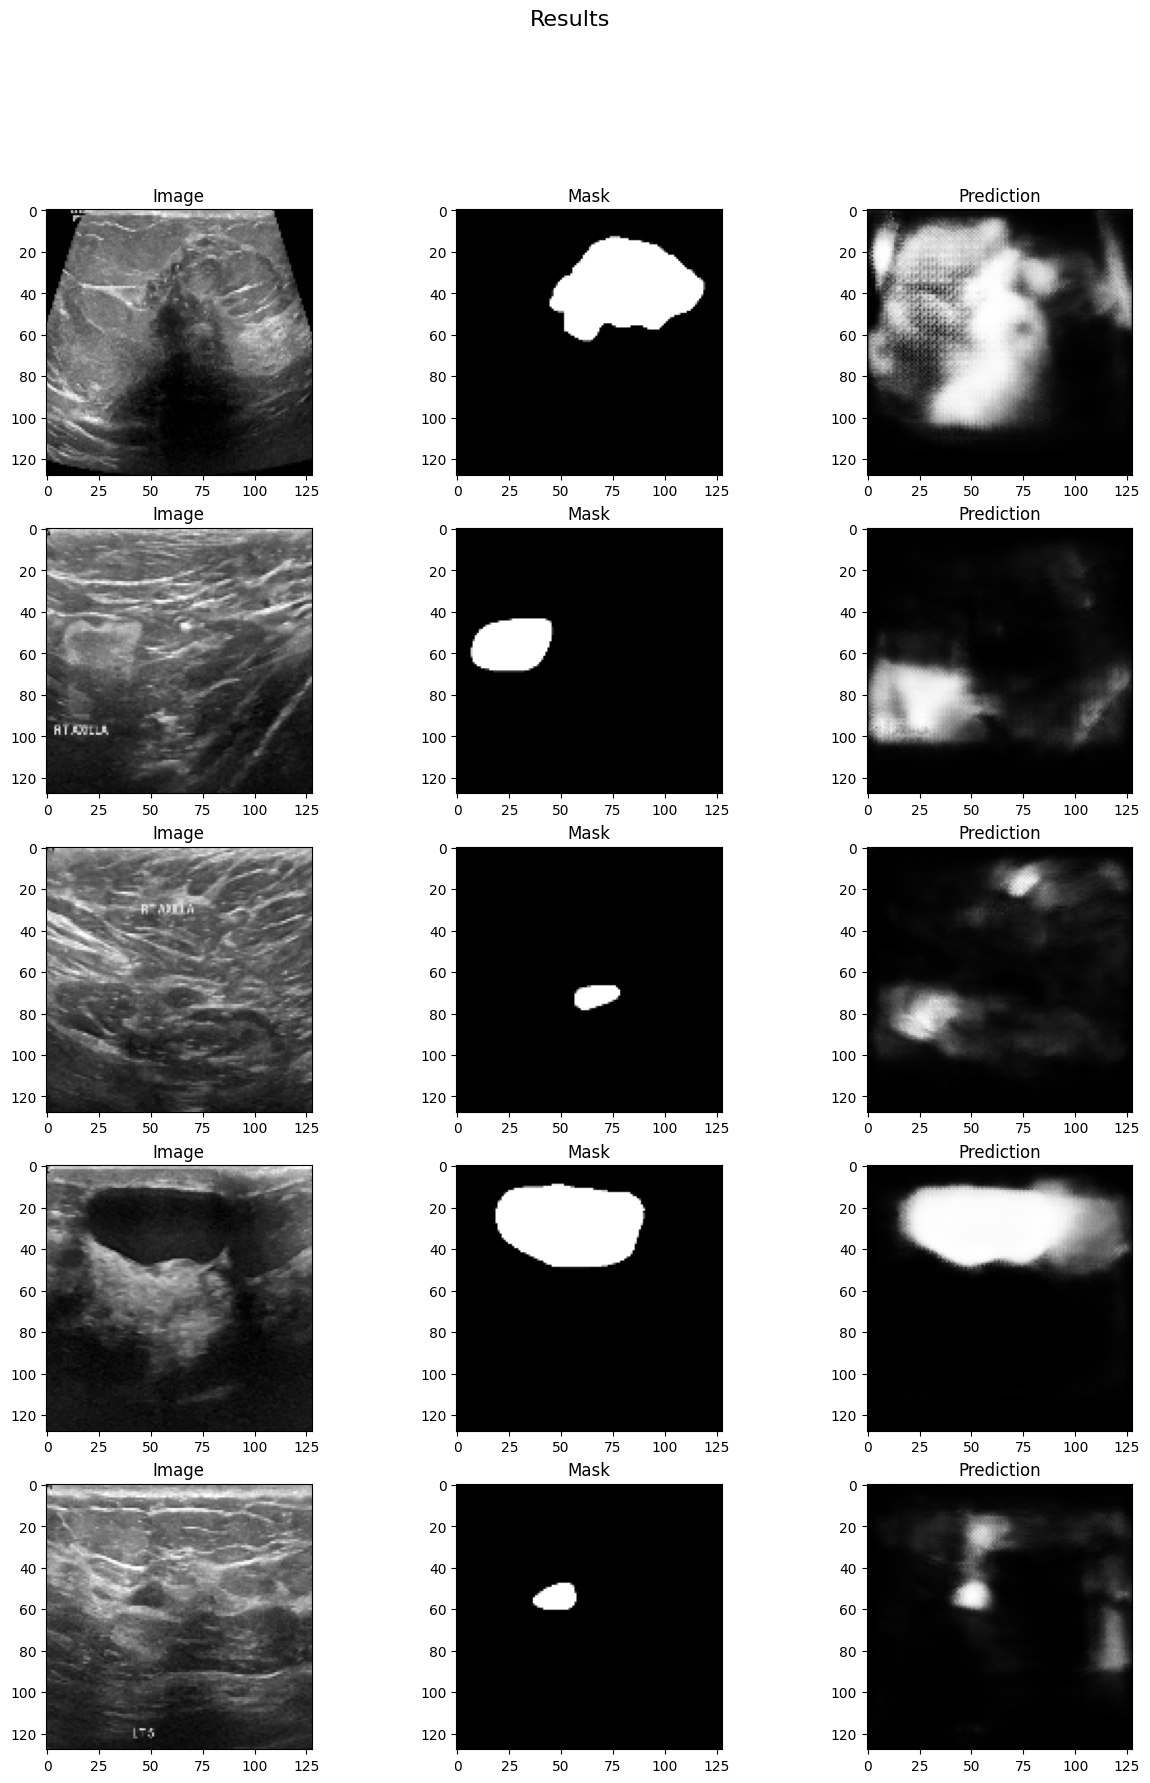

In [ ]:
# Transfer Learning

# Convert the grayscale X_test to RGB
X_test_rgb = np.repeat(X_test, 3, axis=-1)
X_test_rgb = X_test_rgb.reshape(-1, 128, 128, 3)  # Ensuring the shape is (num_samples, 128, 128, 3)

fig, ax = plt.subplots(5, 3, figsize=(15, 20))

# Generate 5 random indices
rand_indices = np.random.randint(0, X_test_rgb.shape[0], 5)

# Iterate through the random indices and plot the results
for i, rand in enumerate(rand_indices):
    ax[i, 0].imshow(X_test_rgb[rand], cmap='gray')
    ax[i, 0].set_title('Image')

    ax[i, 1].imshow(y_test[rand].squeeze(), cmap='gray')
    ax[i, 1].set_title('Mask')

    prediction = model.predict(np.expand_dims(X_test_rgb[rand], 0), verbose=0)
    ax[i, 2].imshow(prediction.squeeze(), cmap='gray')
    ax[i, 2].set_title('Prediction')

fig.suptitle('Results', fontsize=16)
plt.show()


In [ ]:
# Transfer Learning

# Convert grayscale images in X_test to RGB by duplicating the single channel three times
X_test_rgb = np.repeat(X_test, 3, axis=-1)  # This creates (98, 128, 128, 1, 3)

# Reshape X_test_rgb to remove the extra dimension
X_test_rgb = X_test_rgb.reshape(-1, 128, 128, 3)  # Now it should be (98, 128, 128, 3)

print(f"Corrected shape of X_test_rgb: {X_test_rgb.shape}")

y_pred = model.predict(X_test_rgb, verbose=0)

threshold = y_pred > 0.5

print(f"Shape of y_pred: {y_pred.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of threshold: {threshold.shape}")

# Flatten the arrays if needed
y_test_flat = y_test.flatten()
threshold_flat = threshold.flatten()

# Precision
precision = tf.keras.metrics.Precision()
precision.update_state(y_test_flat, threshold_flat)
print(f"Precision: {precision.result().numpy()}")

# Recall
recall = tf.keras.metrics.Recall()
recall.update_state(y_test_flat, threshold_flat)
print(f"Recall: {recall.result().numpy()}")

# Accuracy
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y_test_flat, threshold_flat)
print(f"Accuracy: {accuracy.result().numpy()}")


Corrected shape of X_test_rgb: (98, 128, 128, 3)
Shape of y_pred: (98, 128, 128, 1)
Shape of y_test: (98, 128, 128, 1, 1)
Shape of threshold: (98, 128, 128, 1)
Precision: 0.6321054697036743
Recall: 0.551482081413269
Accuracy: 0.9293312430381775


U-Net from scratch performed better.